In [2]:
%matplotlib notebook
import matplotlib.pyplot as plt

import mygrad as mg
import numpy as np

# Training a Universal Function Approximator

The *universal approximation theorem* states:

Let $ \varphi (\cdot )$ be a nonconstant, bounded, and monotonically-increasing continuous function. Let $ I_m $ denote any compact subset of $ \mathbb {R} ^{m} $. The space of continuous functions $I_m  \mapsto \mathbb {R}$ is denoted by $C(I_{m})$. 

Then, given any $\varepsilon >0$ and any function $f\in C(I_{m})$, there exist $N$ real constants $v_{i},b_{i}\in \mathbb {R}$ and real vectors $w_{i}\in \mathbb {R} ^{m}$, where $i=1,\cdots ,N$, such that we may define:

\begin{equation}
F(\{v_i\}, \{w_i\}, \{b_i\}; x) = \sum_{i=1}^{N} v_{i}\varphi(x \cdot w_{i} + b_{i})
\end{equation}

as an approximate realization of a function $f(x)$, where $f$ is independent of $\varphi$ ; that is,

\begin{equation}
| F( x ) - f ( x ) | < \varepsilon
\end{equation}

for all $ x\in I_{m}$. See that $x \cdot w_{i}$ is the dot product between $x$ and $w_{i}$, which are $m$-dimensional vectors. Each ${b_i}$ is a scalar and each ${v_i}$ is a scalar.

This theorem was first proven in 1989, using the *sigmoid function* as $\varphi$:

\begin{equation}
\varphi(x) = \frac{1}{1 + e^{-x}}
\end{equation}


## Our problem
Here, we will try to find values for the parameters $N,v_{i},b_{i},w_{i}$  (where $i=1,\cdots ,N$) such that $F(x)$ approximates 

\begin{equation}
f(x) = \cos(x)\\
x \in [-2\pi, 2\pi]
\end{equation}

Using the sigmoid function as $\varphi$.

Because $\cos(x)$ maps $[-2\pi, 2\pi]  \mapsto [-1, 1]$, $x$ and $w_{i}$ are scalars. In the future we will be working with high dimensional data, so we will want to treat $x$ and $w_{i}$ as 1-dimensional vectors (i.e. length-1 tensors) here; this will make it trivial to adapt our code to higher dimensional data later on.

We will search for optimal values of $v_{i},w_{i},b_{i}$ via *gradient descent*, using the obvious **loss function**:

\begin{equation}
L(\{v_i\}, \{w_i\}, \{b_i\}; x) = | F(\{v_i\}, \{w_i\}, \{b_i\}; x ) - \cos ( x ) |
\end{equation}

The *number* of parameters to use, $N$, is a **hyper parameter**, which we must find through trial and error.

### Plotting our "activation function"

Import the `sigmoid` from `mygrad.nnet.activations`. Plot this function on the domain $[-10, 10]$. 

Is this a "nonconstant, bounded, and monotonically-increasing continuous function", as demanded for $\varphi$ by the universal approximation theorem?

What does the sigmoid function do to "extreme" values of $x$? What mechanism might this serve? Discuss with neighbors.

<IPython.core.display.Javascript object>


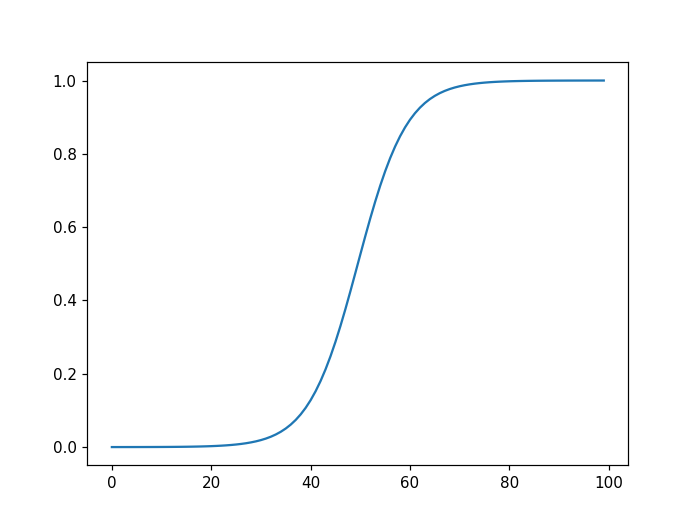

In [3]:
from mygrad.nnet.activations import sigmoid
x = sigmoid(np.linspace(-10, 10, num=100))

#f = lambda x: sigmoid(np.linspace(-10, 10, num=100))

fig, ax = plt.subplots()

ax.plot(x)

### Choosing N and initializing our parameters

Write a function `create_parameters`, which takes an input integer `N`, and initializes the following parameters:

- `w`: a shape-$(1, N)$ `Tensor` with data drawn randomly from `np.random.randn`
- `b`: a shape-$(N,)$ `Tensor` with data drawn randomly from `np.random.randn`
- `v`: a shape-$(N, 1)$ `Tensor` with data drawn randomly from `np.random.randn`

and returns the tuple `(w, b, v)`. You will see why we have these varying shapes soon - it is to accommodate matrix multiplications and broadcasting 

`np.random.randn` draws numbers from a Gaussian distribution (bell curve) that is centered at 0, and has a standard deviation of 1.

In [4]:
def create_parameters(n):
    """ Randomly initializes the parameters w, b, and v by drawing from 
    a Gaussian distribution.
    
    Parameters
    ----------
    n : int 
        The number of parameters to use in our function approximator for
        w, b, and v.

    Returns
    -------
    Tuple[Tensor, Tensor, Tensor]
        Returns w, b, v

    Notes
    -----
    w: shape-(1, n)
    b: shape-(n,)
    v: shape-(n, 1)"""
    w = mg.Tensor(np.random.randn(1, n))
    b = mg.Tensor(np.random.randn(n))
    v = mg.Tensor(np.random.randn(n, 1))
    return w, b, v

### Write a gradient-descent function
Write a gradient descent function that accepts a tuple of tensors and a **learning rate** ($\delta$). 

**For each tensor in a list/tuple**, update the tensor's *underlying numpy array* using to gradient descent. Skip the tensor if its gradient is `None`. Because you are modifying the data of these tensors in-place, this function need not return anything. Write a good docstring for the function.

In [5]:
def grad_descent(params, learning_rate):
    """ Update tensors according to vanilla gradient descent.
    
        Parameters
        ----------
        params : Iterable[mygrad.Tensor]
            A list/tuple of learnable parameters to be updated
            
        learning_rate : float
            The 'step size' to use during the descent
        
        Returns
        -------
        None
            Each parameter in the list should be updated 'in-place'"""
    for tensor in params:
        #if tensor.grad != None:
        tensor.data -= tensor.grad * learning_rate
    
    
    #params.data[params.grad != None] -= params.grad * learning_rate

## Writing our approximating function (a.k.a our "model")

We will now write a `forward_pass` function for our "model", which is the approximating function $F(\{v_i\}, \{w_i\}, \{b_i\}; x )$. Thus this function should accept in the value $x$ (i.e. the "data"), along with the parameters of our model: `w`, `b`, and `v`. 

Note that we will make convenient use of tensors such that: 

- `v` is a tensor that stores all $N$ parameters, $\{v_i\}$
- `w` is a tensor that stores all $N$ parameters, $\{b_i\}$
- `b` is a tensor that stores all $N$ parameters, $\{b_i\}$

### Working with "Batches" of Data
It is computationally inefficient to train our model by passing it one datum, $x$, at a time. Rather, we will want to pass in a **batch** of $M$ pieces of input data, $\{x_{j}\}_{j=0}^{M-1}$, and evaluate our model for each of these values independently.  That is, we will pass on a batch of $M$ pieces of data and produce $M$ corresponding predictions from our model. 

Each prediction is made only on its corresponding piece of input data. Thus, prediction $F(\{v_i\}, \{w_i\}, \{b_i\}; x_j )$ depends only on:

- our model's parameters: $\{v_i\}, \{w_i\}, \{b_i\}$ 
- datum $x_j$

it is **not** impacted by any of the other pieces of data in the batch. This is very important to keep in mind!

We will make our $M$ predictions for the batch using vectorization and not for-loops. Thus `x` will be a shape-$(M, 1)$ numpy-array instead of a single number.

Recall that

\begin{equation}
x_j \cdot w_{i}
\end{equation}

can be evaluated all combinations of $j=1,\cdots ,M$ and $i=1,\cdots ,N$ via simple matrix multiplication between the shape-$(M, 1)$ `x` and the shape-$(1, N)$ `w`, producing a shape-$(M, N)$ output. And thus the following expression:

\begin{equation}
\varphi(x_{j} \cdot w_{i} + b_{i})
\end{equation}

can be performed for all $j$ and $i$ via broadcasting:

```python
sigmoid(mg.matmul(x, w) + b) # matmul[(M,1) w/ (1, N)] + (N,) --> (M, N)
```

Multiplying each such term by $v_{i}$ and summing over $i$ is thus just another matrix multiplication:

\begin{equation}
F(\{v_i\}, \{w_i\}, \{b_i\}; x_j ) = \sum_{i=1}^{N} v_{i}\varphi(x_{j} \cdot w_{i} + b_{i})
\end{equation}

can be performed for each `j` in the batch via:
```python
out1 = sigmoid(mg.matmul(x, w) + b)  # matmul[(M,1) w/ (1, N)] + (N,) --> (M, N)
model_out = mg.matmul(out1, v)       # matmul[(M, N) w/ (N, 1)] --> (M, 1)
```

Thus `model_out` is a shape-$(M, 1)$ tensor that holds the prediction of our model, corresponding with each datum in our shape-(M, 1) batch. 

Write a `forward_pass` function that accepts a batch of shape-(M, 1), the model's parameters, and produces (M, 1) predictions for our approximating function. Include detailed comments about what the input and output shapes are of all the tensors in this forward-pass.

In [6]:
def forward_pass(x, w, b, v):
    """ 
    The approximating function, evaluated at F(xj) for j=0,...,M-1
    
    Parameters
    ----------
    x : numpy.ndarray, shape=(M, 1)
        The batch of input data.
    w : mygrad.Tensor, shape=(1, N)
        The N model parameters associated with {w_i}
    b : mygrad.Tensor, shape=(N, )
        The N model parameters associated with {b_i}
    v : mygrad.Tensor, shape=(N, 1)
        The N model parameters associated with {v_i}
    
    Returns
    -------
    mygrad.Tensor, shape=(M, 1)
        F(xj) for j=0, ..., M-1: the prediction associated with each of the
        M pieces of data in the batch `x`
    """
    out1 = sigmoid(mg.matmul(x, w) + b)  # matmul[(M,1) w/ (1, N)] + (N,) --> (M, N)
    model_out = mg.matmul(out1, v)       # matmul[(M, N) w/ (N, 1)] --> (M, 1)
    return model_out

### Writing a loss function

For the problem at hand, given how the universal approximation theorem is posed, it is quite natural to choose our loss function to be:

\begin{equation}
L(x) = | F( \{v_i\}, \{w_i\}, \{b_i\}; x ) - \cos ( x ) |
\end{equation}

which is called the "L1-loss". Our loss grows linearly with the disagreement between our approximating function (a.k.a our "predictions") and the "true" function.

Note, however, that we want to make predictions size-$M$ batches. Thus we will have:

\begin{equation}
L(x_{j}) = | F(\{v_i\}, \{w_i\}, \{b_i\}; x_j ) - \cos ( x_{j} ) |
\end{equation}

for each $j=1,\cdots ,M$. 

That being said, we want to ultimately have a *single scalar loss*. Let's choose to compute our total loss as the *average* over the $M$ values, $L(x_{j})$. (Note that this average-loss is called "risk" in machine learning and game theory literature).

\begin{equation}
L(\{v_i\}, \{w_i\}, \{b_i\}; \{x_k\} ) = \frac{1}{M}\sum_{j=1}^{M} | F(\{v_i\}, \{w_i\}, \{b_i\}; x_j ) - \cos ( x_{j} ) |
\end{equation}

Write the function `l1_loss`, which accepts the shape-$(M,1)$ batch of **predictions** from our model along with the shape-$(M, 1)$ **true** values (which we are hoping to approximate) and returns the average loss, $L$.

Make sure that you are using functions from mygrad and not numpy, so that we can back-propagate through this loss!

In [7]:
def l1_loss(pred, true):
    """
    Parameters
    ----------
    pred : mygrad.Tensor, shape=(M,)
    true : mygrad.Tensor, shape=(M,)
    
    Returns
    -------
    mygrad.Tensor, shape=()
        The l1-loss averaged over the size-M batch of predictions
    """
    return mg.mean(mg.abs(pred - true))

## Preparing the training data
You will create a numpy-array or *constant-Tensor* that samples $[-2\pi, 2\pi]$ 1,000 evenly-spaced points. Call this `train_data`. This should have the shape of (1000, 1). (You will do this lower down in the notebook).

Why is it important that we use numpy-arrays or constant tensors? Why would it be inefficient to perform back-propagation if our training data were non-constant tensors? Discuss with your neighbors.

### Training Our Approximating Function! 

We will use the handy 'noggin' package to keep track of how our loss is evolving during training. The following code will create a plotter that will keep track of "loss", and will refresh itself every 2 seconds, during training:

```python
from noggin import create_plot
plotter, fig, ax = create_plot(metrics=["loss"])
ax.set_ylim(0, 1)
```

We will need to make take randomized "batches" of our training data, and use them to train our model. Each time we process all of the batches in our training data, we have completed an "epoch" of training.

Below, we will use batches of size-25. Thus we will need to process $1000/25 = 40$ batches to complete an epoch of training.

Here, we will set up our training data, initialize our model's parameters, set our batch size, and define the function that we are attempting to approximate. We will also create a plot that updates during training

<IPython.core.display.Javascript object>


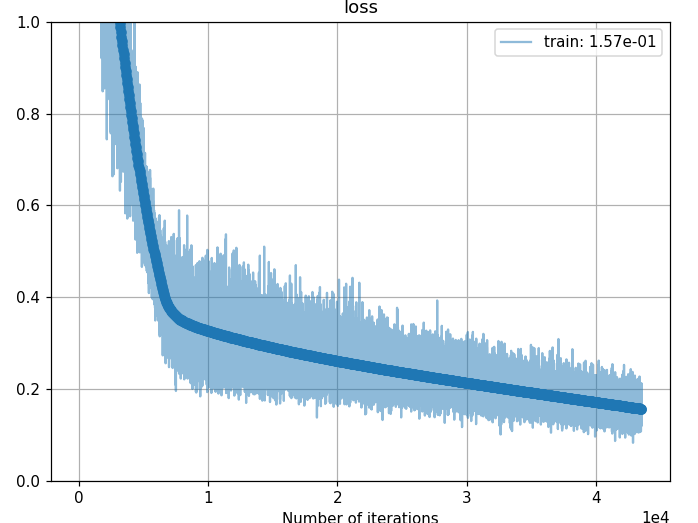

In [59]:
# Running this code will recreate your model, re-initializing all of its parameters
# Thus you must re-run this cell if you want to train your model from scratch again.

# Create the noggin figure using the code snippet above
from noggin import create_plot
plotter, fig, ax = create_plot(metrics=["loss"])
ax.set_ylim(0, 1)

# Create the shape-(1000,1) training data
train_data = np.linspace(-1.5 * np.pi,1.5 * np.pi, num=1000).reshape(1000, 1)

# Create your parameters using your function `create_parameters`; 
# start off with N=10 for the number of model parameters
# to use for defining F(x)
w, b, v = create_parameters(1000)

# Set `batch_size = 25`: the number of predictions that we will make in each training step
batch_size = 25

# Define the function `true_f`, which should just accept `x` and return `np.cos(x)`
# (or any other function that you want to approximate later on)
true_f = lambda x: np.cos(x)

# we will store our model's weights in this list every 10 epochs 
#so that we can assess what our model's predictions look like mid-training
params = [] 

In [ ]:
# running this code will train your model; you can run it consecutively,
# with different learning rates to continue training your model.

# set your "learning rate": the scaling parameter in gradient descent
# try a value of 0.01 to start
learning_rate = 0.00005

# We will train for 1000 epochs; you can change this if you'd like
for epoch_cnt in range(4000):
    idxs = np.arange(len(train_data))  # -> array([0, 1, ..., 9999])
    # shuffles these indices; we will use this to draw random batches
    # from our training data
    np.random.shuffle(idxs)  
    
    # Let's keep track of our model's progress. Every 10 epochs we'll
    # record our model's weights so that we can visualize what its 
    # predictions look like as it was training.
    if epoch_cnt % 10 == 0:
        params.append((w.data.copy(), b.data.copy(), v.data.copy()))
        
    for batch_cnt in range(0, len(train_data)//batch_size):
        batch_indices = idxs[batch_cnt*batch_size : (batch_cnt + 1)*batch_size]
        batch = train_data[batch_indices]  # random batch of our training data
        
        # compute the predictions for this batch: F(x)
        fx = forward_pass(batch, w, b, v)
        
        # compute the true (a.k.a desired) values for this batch: f(x) 
        true_x = true_f(batch)
        
        # compute the loss associated with our predictions
        loss = l1_loss(fx, true_x)
        
        # back-propagate through your computational graph through your loss
        # this will compute: dL/dw, dL/db, dL/dv
        loss.backward()
        
        # execute your gradient descent function, passing all of your model's
        # parameters (w, b, v), and the learning rate. This will update your
        # model's parameters based on the loss that was computed
        grad_descent([w, b, v], learning_rate)
        
        # FOR THE LOVE OF ALL THAT IS GOOD: NULL YOUR GRADIENTS
        loss.null_gradients()
        
        # this will record the current loss, and will plot it
        plotter.set_train_batch({"loss" : loss.item()},
                               batch_size=batch_size)
    plotter.set_train_epoch()

# this will ensure you plotted the most recent data
plotter.plot()

Remember that we were just updating our model's parameters, $\{v_i\}, \{w_i\}, \{b_i\}$, using gradient descent so as to minimize our loss: L(x) = $| F( \{v_i\}, \{w_i\}, \{b_i\}; x ) - \cos ( x ) |$

Thus we should expect to see that $F( \{v_i\}, \{w_i\}, \{b_i\}; x ) \approx \cos ( x )$

To evaluate the quality of your model (i.e. your approximating function $F(x)$), plot $f(x)$ (the desired function) and $F(x)$ on the sample plot. Use `train_data` as your `x` values. 

<IPython.core.display.Javascript object>


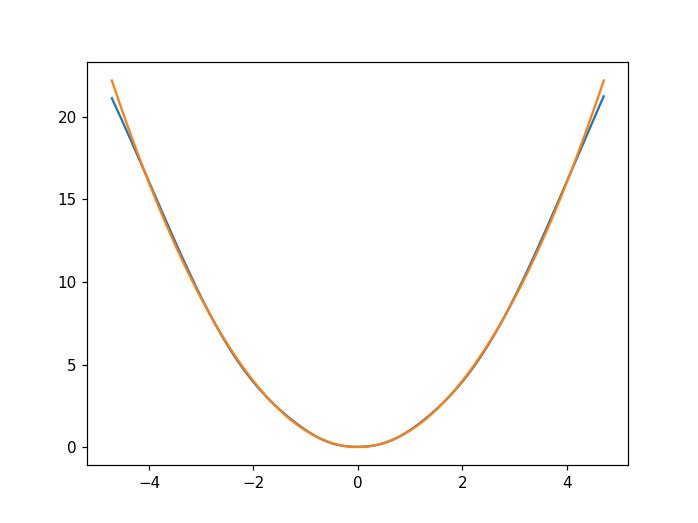

In [52]:
img, ax = plt.subplots()

ax.plot(train_data, forward_pass(train_data, w, b, v))
ax.plot(train_data, true_f(train_data))

Let's see what our model looked like *as it was training/learning*. Run the following cell to see the true function (plotted in blue) and our approximating function (plotted in orange)

<IPython.core.display.Javascript object>


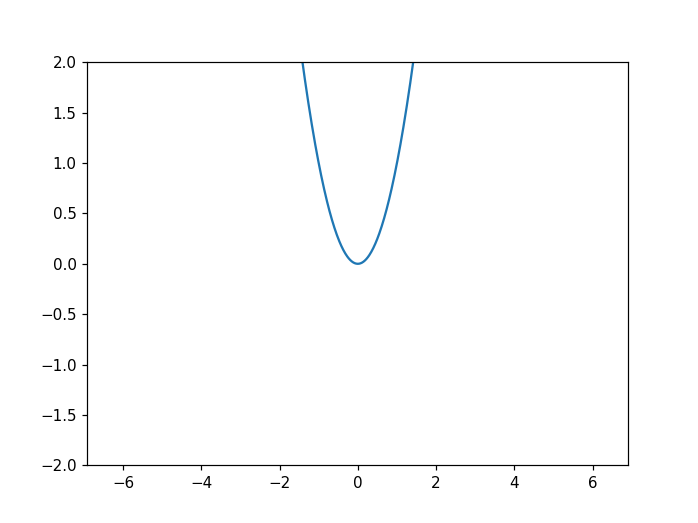

In [53]:
# execute this cell

from matplotlib.animation import FuncAnimation

x = np.linspace(-2*np.pi, 2*np.pi, 1000)

fig, ax = plt.subplots()
ax.plot(x, true_f(x))
ax.set_ylim(-2, 2)
im, = ax.plot(x.squeeze(), forward_pass(x[:, np.newaxis], *params[0]).squeeze())


def update(frame):
    # ax.figure.canvas.draw()
    im.set_data(x.squeeze(), forward_pass(x[:, np.newaxis], *params[frame]).squeeze())
    return im,

ani = FuncAnimation(fig, update, frames=range(0, len(params)), interval=20,
                    blit=True, repeat=True, repeat_delay=1000)


### Things to Try (be sure to preserve any good code you have before trying these things)
- Once your loss curve (often called the "learning curve") plateaus, try reducing the learning rate and resume training. This will likely lower your loss further.
- Once you have a good model, try plotting $f(x)$ and $F(x)$ *beyond* the domain that you trained it on. For example, try plotting them on $[-4\pi, 4\pi]$. What do you see? Is this reasonable? Discuss with a neighbor.
- Try decreasing the the parameter-number in your model from $N=10$ down to $N=1$. Thus `w` will have the shape (1, 1) instead of (1, 10), etc. Train this model as best you can, and plot $F(x)$. What shape does this take? Can you explain why?
- Using $N=10$, repeat your training but train on the domain $[2\pi, 6\pi]$. Are you able to get your model to train well? Why should shifting the domain have any affect if $f(x)$ is perfectly periodic. Consider what special properties our original domain, $[-2\pi, 2\pi]$ has. Consider, also, how we initialize our model's parameters. Discuss with your neighbor what you suspect might be the issue here. You can use `noggin` to plot the mean values of `w`, `v`, and `b` as you train. You can also plot the mean values of the gradients that are back-propagating through your model, with some minor modifications to your code. This is very interesting to visualize.
- Fit a different $f(x)$ other than cosine. Do you need more parameters to approximate more complicated functions?
- Try increasing $N$ to $N=1000$. You may need to try adjusting your learning rate during training, lowering it as you go. Does increasing $N$ make things better or worse in this instance?

In [28]:
# plotting F(x) outside of its training domain

pass

In [ ]:
# training the model using N=1

# INTERPRETATION: For N=1, F(x) = v * sigmoid(x*w + b), thus F(x) must
# have the form of a sigmoid function (albeit a shallow one)

pass

In [ ]:
pass

In [ ]:
# visualizing w_grad.mean()

pass